
# 有限元算例-Poisson方程求解

本节将引导您使用 FEALPy 完成 Poisson 方程的有限元求解，现定义如下数学模型：

$$
\begin{cases}
-\Delta u = f & \text{在 } \Omega = [-1,1]^2 \\
u = g & \text{在 } \partial \Omega
\end{cases}
$$

其中我们定义真解为：

$$
u(x, y) = \cos(\pi x)\cos(\pi y)
$$

源项为：

$$
f(x,y) = 2\pi^2 \cos(\pi x) \cos(\pi y)
$$

变分形式为：

$$
(\nabla u_h, \nabla v_h) = (f, v_h), \quad \forall v_h \in V_h
$$


### 1. 定义 PDE 模型

In [1]:
from fealpy.backend import backend_manager as bm
from fealpy.decorator import cartesian

# 定义域
def domain():
    return [0, 1, 0, 1]

# 真解
@cartesian
def solution(p):
    x = p[..., 0]
    y = p[..., 1]
    pi = bm.pi
    val = bm.cos(pi*x)*bm.cos(pi*y)
    return val

# 源项
@cartesian
def source(p):
    x = p[..., 0]
    y = p[..., 1]
    pi = bm.pi
    val = 2*pi*pi*bm.cos(pi*x)*bm.cos(pi*y)
    return val

# dirichlet 边界条件
@cartesian
def dirichlet(p):
    return solution(p)

### 2. 进行参数配置和初始化

设置后端

In [2]:
from fealpy.backend import backend_manager as bm

backend = 'numpy'
device = 'cpu'
bm.set_backend(backend)

导入日志工具

In [3]:
from fealpy.utils import timer
from fealpy import logger

logger.setLevel('WARNING')
tmr = timer()
next(tmr)

设置初始网格和加密次数

In [10]:
from fealpy.mesh import TriangleMesh

mesh = TriangleMesh.from_box(domain(), nx=4, ny=4)
maxit = 4

定义误差存储矩阵

In [11]:
errorMatrix = bm.zeros((1, maxit), dtype=bm.float64)

### 3. 有限元求解

流程包含：

(1)构建Lagrange有限元空间

(2)组装刚度矩阵 $A$ 和载荷向量 $F$

(3)处理Dirichlet边界条件

(4)求解线性系统 $A u_h = F$

(5)计算L2误差 $\|u - u_h\|_{L^2(\Omega)}$

(6)网格均匀加密

In [12]:
from fealpy.functionspace import LagrangeFESpace
from fealpy.fem import BilinearForm, ScalarDiffusionIntegrator
from fealpy.fem import LinearForm, ScalarSourceIntegrator
from fealpy.fem import DirichletBC
from fealpy.solver import cg

for i in range(maxit):
    space = LagrangeFESpace(mesh, p=1)
    tmr.send(f'第{i}次空间时间')
    uh = space.function()

    D = ScalarDiffusionIntegrator(q=3)
    bform = BilinearForm(space)
    bform.add_integrator(D)
    A = bform.assembly()
    lform = LinearForm(space)
    lform.add_integrator(ScalarSourceIntegrator(source, q=3))
    F = lform.assembly()
    tmr.send(f'第{i}次矩阵组装时间')
    gdof = space.number_of_global_dofs()
    A, F = DirichletBC(space, gd = dirichlet).apply(A, F)
    tmr.send(f'第{i}次边界处理时间')
    uh[:] = cg(A, F)
    tmr.send(f'第{i}次求解器时间')
    errorMatrix[0, i] = mesh.error(solution, uh)
    if i < maxit-1:
        mesh.uniform_refine(n=1)
    tmr.send(f'第{i}次误差计算及网格加密时间')

### 4. 误差分析和收敛阶计算

In [13]:
next(tmr)
print("最终误差",errorMatrix)
print("order : ", bm.log2(errorMatrix[0,:-1]/errorMatrix[0,1:]))

Timer received None and paused.
   ID       Time        Proportion(%)    Label
-------------------------------------------------
    1      8.096 [s]           99.428    第0次空间时间
    2      8.227 [ms]           0.101    第0次矩阵组装时间
    3    810.385 [us]           0.010    第0次边界处理时间
    4    322.342 [us]           0.004    第0次求解器时间
    5      2.303 [ms]           0.028    第0次误差计算及网格加密时间
    6    121.593 [us]           0.001    第1次空间时间
    7      3.967 [ms]           0.049    第1次矩阵组装时间
    8    487.566 [us]           0.006    第1次边界处理时间
    9    395.536 [us]           0.005    第1次求解器时间
   10      1.688 [ms]           0.021    第1次误差计算及网格加密时间
   11    554.323 [us]           0.007    第2次空间时间
   12      4.985 [ms]           0.061    第2次矩阵组装时间
   13    447.750 [us]           0.005    第2次边界处理时间
   14    957.251 [us]           0.012    第2次求解器时间
   15      2.735 [ms]           0.034    第2次误差计算及网格加密时间
   16     45.776 [us]           0.001    第3次空间时间
   17     11.442 [ms]           0.141    第3次矩阵组装时间


### 5. 结果可视化
在单元重心处计算真解和数值解，并进行可视化比较

findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
/home/wpx/wpx-repository/codevene/fealpy/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wpx/wpx-repository/codevene/fealpy/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'Microsoft YaHei' not found.
/home/wpx/wpx-repository/codevene/fealpy/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wpx/wpx-repository/codevene/fealpy/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIF

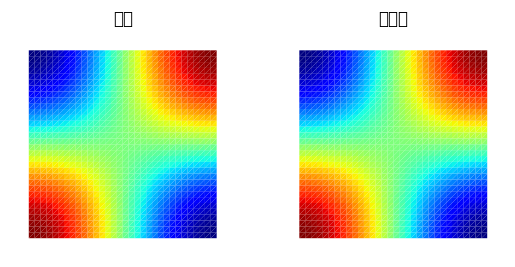

In [14]:
from matplotlib import pyplot as plt

bc = bm.array([[1/3, 1/3, 1/3]], dtype=bm.float64)
ps = mesh.bc_to_point(bc)
u = solution(ps)
uh = uh(bc)

fig, axes = plt.subplots(1, 2)
mesh.add_plot(axes[0], cellcolor=u, linewidths=0)
axes[0].set_title('真解', fontname='Microsoft YaHei')
mesh.add_plot(axes[1], cellcolor=uh, linewidths=0)
axes[1].set_title('数值解', fontname='Microsoft YaHei')
plt.show()